# Linear Regression approach

In [1]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import numpy as np
import librosa
import librosa.display
from scipy.io import wavfile
import numpy as np
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 4.0)

### Loading data 

In [2]:
A_train = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/A_train.csv', delimiter=',', ndmin=2)
A_dev = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/A_dev.csv', delimiter=',', ndmin=2)

B_train = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/B_train.csv', delimiter=',', ndmin=2)
B_dev = np.loadtxt('/home/srg/Documents/MSU/EEG/data/50ms/B_dev.csv', delimiter=',', ndmin=2)

A_dev = torch.from_numpy(A_dev.reshape(10, 9, -1))
B_dev = torch.from_numpy(B_dev.reshape(10, 9, -1))
print(A_train.shape, A_dev.shape, B_train.shape, B_dev.shape)

(900, 1176) torch.Size([10, 9, 1176]) (900, 1542) torch.Size([10, 9, 1542])


### Hyper parameters 

In [39]:
input_size = A_train.shape[1]
hidden_size = 500 
num_epochs = 5000
batch_size = 10
learning_rate = 0.001

FRAME_SIZE = 512
SR = 22050
HOP_LENGTH = 118

### Dataloader

In [40]:
class Loader(Dataset):

    def __init__(self):

        self.n_samples = int(A_train.shape[0] / 9)

        self.x_data = torch.from_numpy(A_train)
        self.y_data = torch.from_numpy(B_train)

    def __getitem__(self, index):
        return self.x_data[index * 9 : (index + 1) * 9, :], self.y_data[index * 9 : (index + 1) * 9, :]

    def __len__(self):
        return self.n_samples

In [41]:
train_loader = DataLoader(dataset=Loader(),
                          batch_size=batch_size,
                          shuffle=True)

### Model 

In [42]:
class Model(nn.Module):

    def __init__(self, input_size, hidden_size, out_size):
        super(Model, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [43]:
model = Model(A_train.shape[1], hidden_size, B_train.shape[1])
model.double()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_samples = len(train_loader)

### Training

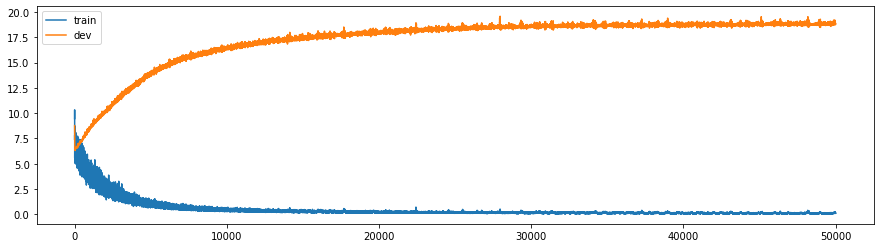

In [44]:
writer_train = SummaryWriter("./runs/train")
writer.add_graph(model, A_dev[0])
writer_dev = SummaryWriter("./runs/dev")

train_losses = np.empty(0)
dev_losses = np.empty(0)

for epoch in range(num_epochs):

    for i, (a, b) in enumerate(train_loader):
        
        # forward pass
        outputs = model(a)
        loss = criterion(outputs, b)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # info 
        with torch.no_grad():
            train_losses = np.append(train_losses, loss)
            writer_train.add_scalar('loss', loss.item(), global_step=epoch*len(train_loader)+i)
            outputs = model(A_dev)
            loss = criterion(outputs, B_dev)
            dev_losses = np.append(dev_losses, loss)
            writer_dev.add_scalar('loss', loss.item(), global_step=epoch*len(train_loader)+i)
            

writer_train.close()
writer_dev.close()
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### Testing

In [26]:
def restore(D, frame_size, hop_length, epochs=100, window='hann'):
    
    D = np.concatenate((np.zeros((D.shape[0], 1)), D, np.zeros((D.shape[0], 1))), axis=1)
    mag, _ = librosa.magphase(D)
    #mag = np.abs(D)
    
    phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=mag.shape))
    x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, window=window)
    
    for i in range(epochs):
        _, phase = librosa.magphase(librosa.stft(x_, n_fft=frame_size, hop_length=hop_length, center=False,
                                                 window=window))
        x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, window=window)
        
    return x_[hop_length:-hop_length]

In [45]:
with torch.no_grad():
    restored_train = model(torch.from_numpy(A_train.reshape(-1, 9, 1176)))
    restored_dev = model(A_dev.reshape(-1, 9, 1176))
    
print(restored_train.shape, restored_dev.shape)

torch.Size([100, 9, 1542]) torch.Size([10, 9, 1542])


In [46]:
restored_train = restored_train.reshape(-1, 1542).numpy().reshape(-1, 6, 257).reshape(-1, 257).T
restored_dev = restored_dev.reshape(-1, 1542).numpy().reshape(-1, 6, 257).reshape(-1, 257).T

x_ = restore(restored_train, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=30)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x_)

x_ = restore(restored_dev, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=30)
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/2.wav', SR, x_)